## Stability maximum
Make Figure S4, which shows stability $S$ of a moist pseudoadiabatic column as a function of surface temperature. The stratosphere is assumed to be isothermal, with temperature 200K. $\partial S/\partial p$ is also shown for the same columns, and an approximation (equation 15 in supplement).

In [44]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [50]:
#constants we'll need
g = 9.8
cp = 1005.
Lv = 2.5 * 10. ** 6
Rd = 287.058
Rv = 461.
gam_d = -g / cp 

#grab pressures and heights from simulation 
press = np.load( "3D_data/SAM_press.dat" )
z = np.load( "3D_data/SAM_z.dat" )

p = len(press )

In [51]:
#Now make pseudoadiabats and calculate stabilities
Ts = np.arange(290., 311., 1.)
t = len( Ts )
T = np.zeros( (t,  p ) )
qsat = np.zeros( ( t, p))
gam = np.zeros( ( t, p))

def sat_spec_hum(T, press):
    #make sure press is in units of Pa
    estar = (0.61094 * np.exp( 17.625 * (T - 273.15) / ( (T - 273.15) + 243.04) ) ) * 1000.
    return 0.622 * estar / (press - estar)

#Surface values
for i in range( t ):
    T[i, 0] = Ts[i]
    qsat[i, 0] = sat_spec_hum(T[i, 0], press[0] * 100.)
 
for j in range( t ):
    for i in range( 1, p):
        gam[j, i - 1] = gam_d * (1. + Lv * qsat[j, i - 1] / Rd / T[j, i - 1]) / (1. + Lv ** 2 * qsat[j, i - 1] / Rv / T[j, i - 1] ** 2 / cp)
        T[j, i] = T[j, i - 1] + (z[i] - z[i- 1]) * gam[j, i - 1]
        if T[j, i] <= 200.:
            T[j, i] = 200.

        qsat[j, i] = sat_spec_hum(T[j, i], press[i] * 100.)

In [52]:
stability = np.zeros( ( t, p))
dS_dp = np.zeros( ( t, p))

for i in range( t):
    stability[i] = np.gradient( qsat[i], press * 100.) * Lv / cp
    dS_dp[i] = np.gradient( stability[i], press * 100.)
    
stability = np.swapaxes( stability, 0, 1)
dS_dp = np.swapaxes( dS_dp, 0, 1)

In [53]:
#approximation from equation 15 in supplement
H = Rd * Ts / g #scale height
del_gamma = gam - gam_d #difference between lapse-rate and dry lapse-rate
dS_dp_approx = np.expand_dims(H, 1) / np.expand_dims(press, 0) / 100. * (np.gradient(del_gamma, press * 100., axis = 1) - del_gamma / np.expand_dims(press, 0) / 100.)

#predict where dS_dp changes sign:
prediction = np.zeros( t )
for i in range( t ):
    for j in range( p ):
        if dS_dp_approx[i, j] > 0. and dS_dp_approx[i, j - 1] < 0.:
            prediction[i] = press[j] #rough and dirty, no interpolation
            break

([<matplotlib.axis.XTick at 0x149cfd690>,
 [Text(290.0, 0, '290'),
  Text(295.0, 0, '295'),
  Text(300.0, 0, '300'),
  Text(305.0, 0, '305'),
  Text(310.0, 0, '310')])

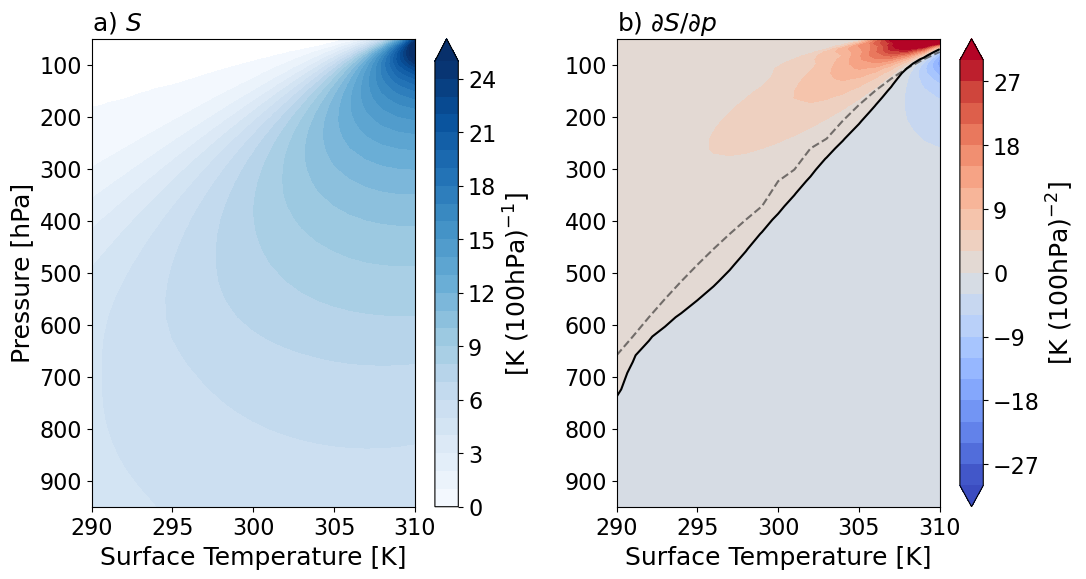

In [54]:
fig = plt.figure( figsize = (12, 6) )
plt.subplots_adjust(left = 0.126, right = 0.9, bottom = 0.13, top = 0.91, hspace = 0.85, wspace = 0.3)

plt.subplot(1, 2, 1) 
plt.title("a) $S$", fontsize = 18, loc = "left")

levs = np.arange(0., 26., 1.)
plt.contourf( Ts, press, stability* 10. ** 4, levs, cmap = plt.cm.Blues, extend = "max" )
cb = plt.colorbar()
cb.set_label("[K (100hPa)$^{-1}$]", fontsize = 18)
cb.ax.tick_params(labelsize=16)
plt.ylim([950., 50.])
plt.ylabel("Pressure [hPa]", fontsize = 18)
plt.yticks(fontsize = 16)
plt.xlabel("Surface Temperature [K]", fontsize = 18)
plt.xticks([290., 295., 300., 305., 310.], fontsize = 16)


plt.subplot(1, 2, 2)
plt.title("b) $\partial S/\partial p$", fontsize = 18, loc = "left")

v = np.arange( -30., 33., 3.)
plt.contourf( Ts, press, dS_dp * 10. ** 8, v, cmap = plt.cm.coolwarm, extend = "both")
cb = plt.colorbar()
cb.set_label("[K (100hPa)$^{-2}$]", fontsize = 18)
cb.ax.tick_params(labelsize=16)

plt.plot(Ts, prediction[:], 'k--', alpha = 0.5)

plt.ylim([950., 50.])
levs = [-1000000., 0., 1000000.]
plt.contour( Ts, press, dS_dp * 100. * 100., levs, colors = 'k')
plt.yticks(fontsize = 16)
plt.xlabel("Surface Temperature [K]", fontsize = 18)
plt.xticks([290., 295., 300., 305., 310.],fontsize = 16)

#plt.savefig("Stability_maximum.pdf")
#plt.savefig("Stability_maximum.png")